In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import keras
from datetime import datetime

In [15]:
keras.__version__

'2.10.0'

In [16]:
end = datetime.now()
start = datetime(end.year - 10, end.month, end.day)


stock = 'GOOG'
data = yf.download(stock, start, end)

[*********************100%%**********************]  1 of 1 completed


In [17]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-02-26,30.485731,30.607277,30.230688,30.390341,30.390341,79585191
2014-02-27,30.346006,30.491461,30.311634,30.366428,30.366428,50588912
2014-02-28,30.394573,30.490463,30.042892,30.277761,30.277761,92890878
2014-03-03,30.056091,30.083241,29.692205,29.954971,29.954971,84507572
2014-03-04,30.261572,30.286480,30.124586,30.259331,30.259331,58928052
...,...,...,...,...,...,...
2024-02-20,140.940002,143.328995,140.800003,142.199997,142.199997,18625600
2024-02-21,142.639999,143.979996,141.910004,143.839996,143.839996,16499600
2024-02-22,146.119995,146.199997,144.009995,145.320007,145.320007,23024700


In [18]:
## get the moving avaerage of the last 100 days
ma_100 = data.Close.rolling(100).mean()

In [19]:
data.dropna(inplace = True)

In [20]:
train_data = pd.DataFrame(data.Close[0: int(len(data)*0.80)])
test_data = pd.DataFrame(data.Close[int(len(data)*0.80): len(data)])

In [21]:
## scaling the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [22]:
data_train_scaled = scaler.fit_transform(train_data)

In [23]:
x = []
y = []
for i in range(100, data_train_scaled.shape[0]):
    x.append(data_train_scaled[i-100: i])
    y.append(data_train_scaled[i,0])

In [24]:
x, y = np.array(x), np.array(y)

In [25]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [26]:
model = Sequential()
model.add(LSTM(units=50, activation = 'relu', return_sequences = True, input_shape = ((x.shape[1], 1))))
model.add(Dropout(0.2))
model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))
model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1))
          

In [27]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x, y, epochs = 14, batch_size = 32, verbose = 1)

Epoch 1/14
60/60 [==============================] - 72s 1s/step - loss: 0.0264
Epoch 2/14
60/60 [==============================] - 65s 1s/step - loss: 0.0057
Epoch 3/14
60/60 [==============================] - 65s 1s/step - loss: 0.0056
Epoch 4/14
60/60 [==============================] - 65s 1s/step - loss: 0.0040
Epoch 5/14
60/60 [==============================] - 65s 1s/step - loss: 0.0039
Epoch 6/14
60/60 [==============================] - 92s 2s/step - loss: 0.0036
Epoch 7/14
60/60 [==============================] - 109s 2s/step - loss: 0.0031
Epoch 8/14
60/60 [==============================] - 102s 2s/step - loss: 0.0035
Epoch 9/14
60/60 [==============================] - 72s 1s/step - loss: 0.0034
Epoch 10/14
60/60 [==============================] - 80s 1s/step - loss: 0.0032
Epoch 11/14
60/60 [==============================] - 64s 1s/step - loss: 0.0028
Epoch 12/14
60/60 [==============================] - 64s 1s/step - loss: 0.0030
Epoch 13/14
60/60 [============================

In [28]:
past_100_days = train_data.tail(100)
test_data = pd.concat([past_100_days, test_data], ignore_index=True)

In [29]:
test_data_scaled = scaler.fit_transform(test_data)

In [30]:
x = []
y = []
for i in range(100, test_data_scaled.shape[0]):
    x.append(test_data_scaled[i-100: i])
    y.append(test_data_scaled[i,0])
x, y = np.array(x), np.array(y)

In [31]:
y_pred = model.predict(x)

16/16 [==============================] - 3s 142ms/step


In [32]:
scale = 1/scaler.scale_

In [33]:
y_pred = y_pred*scale

In [34]:
y = y*scale

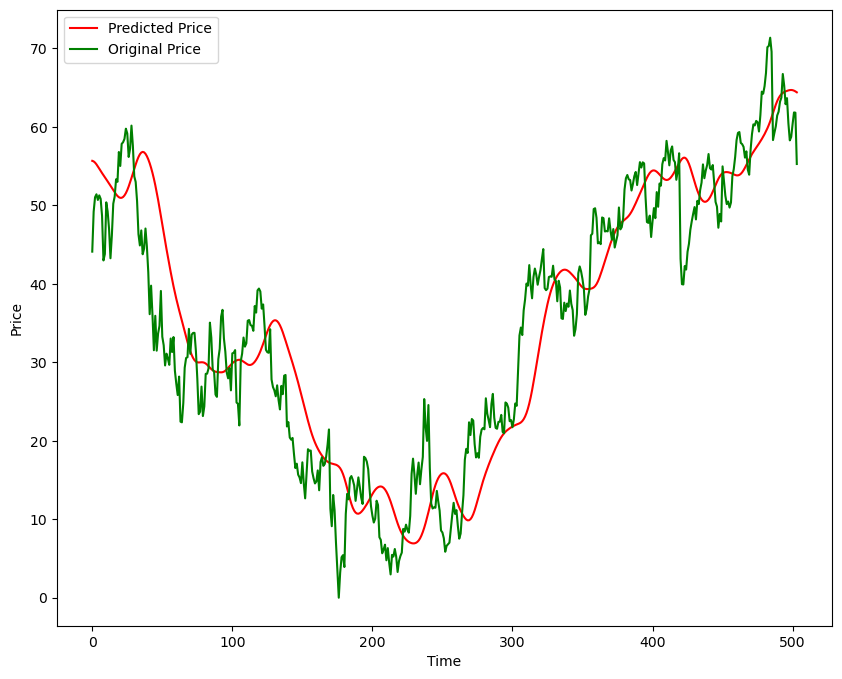

In [35]:
plt.figure(figsize = (10,8))
plt.plot(y_pred, 'r', label = "Predicted Price")
plt.plot(y, 'g', label = 'Original Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [36]:
model.save('model.keras')